This notebook is based on https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction

Changes:


1.   Use seaborn instead of plotly
2.   Use PyCarat for predictive modelling


Link to dataset: https://www.kaggle.com/blastchar/telco-customer-churn

To install PyCarat: !pip install pycaret



In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Stuff/DS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Stuff/DS


# **0. Load Data**



In [2]:
import pandas as pd

telcom = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **1. Data Overview**


In [3]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [4]:
telcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# **2. Data Manipulation**

In [5]:
import numpy as np


#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

# **3. Data Exploratory Analysis**

**3.1 Class Balance - Churn vs Not Churn**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(-1.1170730613805746,
 1.1008130029228844,
 -1.1102627542185721,
 1.1193818573644263)

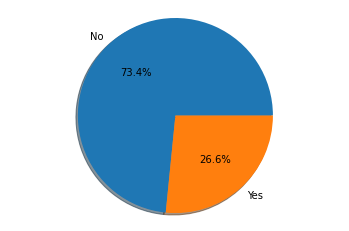

In [6]:
import seaborn as sns
import matplotlib.pyplot  as plt
val_counts = telcom["Churn"].value_counts()

#labels
lab = val_counts.keys().tolist()
#values
val = val_counts.values.tolist()

fig1, ax1 = plt.subplots()
ax1.pie(val, labels=lab, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

**3.2 Churn vs Not Churn - Categorical Features**

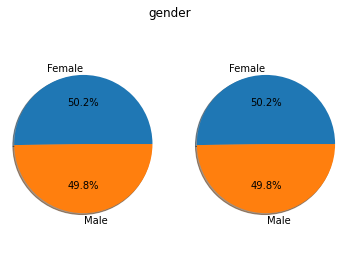

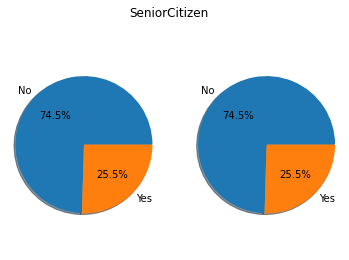

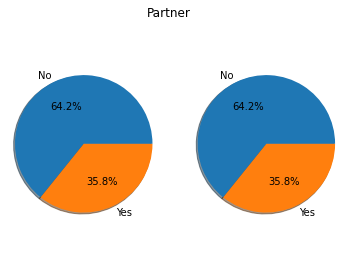

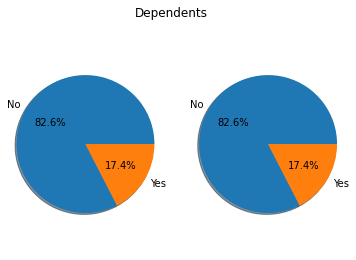

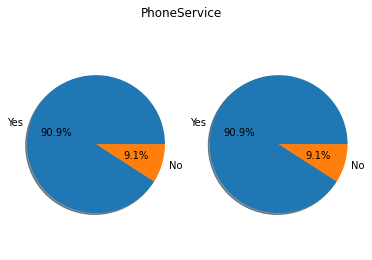

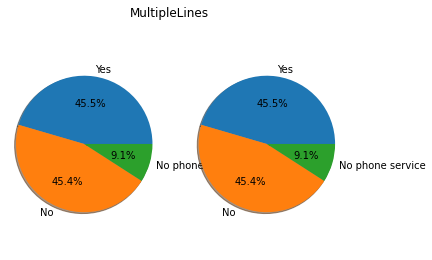

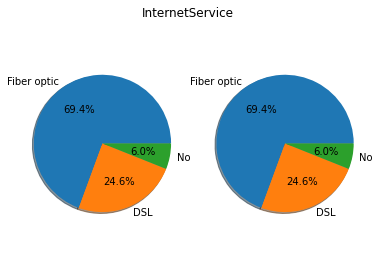

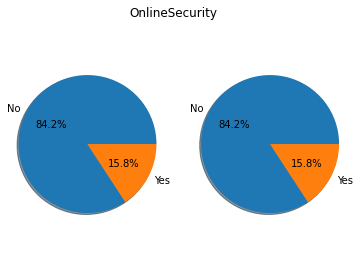

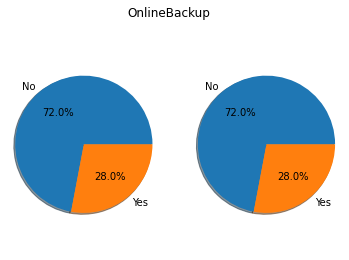

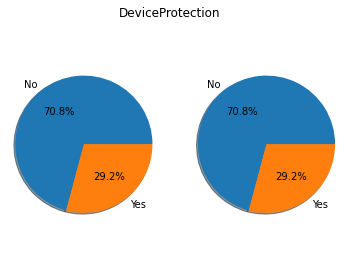

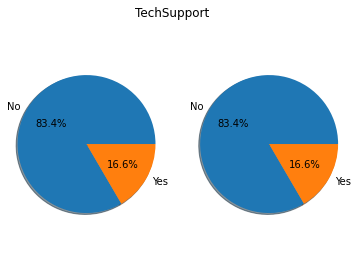

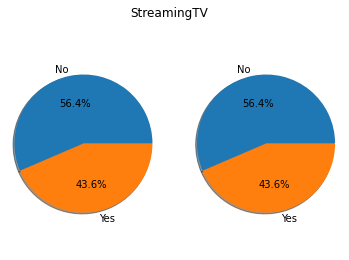

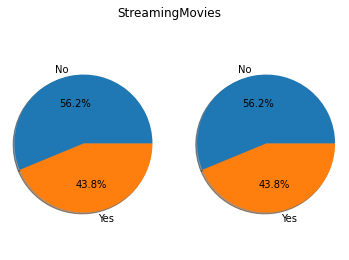

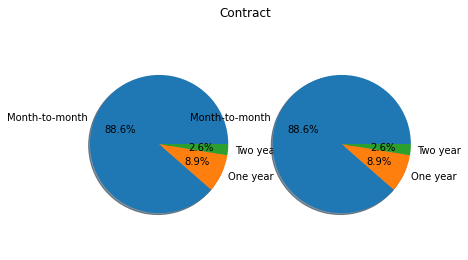

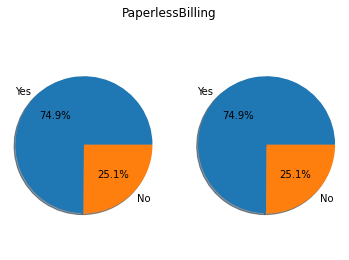

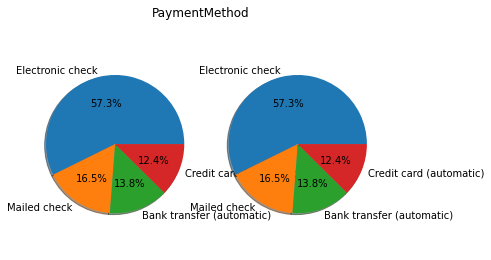

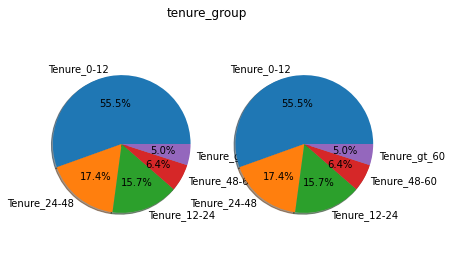

In [7]:
def plotpie(col):
  val_counts_churn = churn[col].value_counts()
  #labels
  lab_churn = val_counts_churn.keys().tolist()
  #values
  val_churn = val_counts_churn.values.tolist()

  val_counts_notchurn = not_churn[col].value_counts()
  #labels
  lab_notchurn = val_counts_churn.keys().tolist()
  #values
  val_notchurn = val_counts_churn.values.tolist()

  fig1, (ax1,ax2) = plt.subplots(1,2)
  fig1.suptitle(col)
  ax1.pie(val_churn, labels=lab_churn, autopct='%1.1f%%', shadow=True)
  ax1.axis('equal')
  ax2.pie(val_notchurn, labels=lab_notchurn, autopct='%1.1f%%', shadow=True)
  ax2.axis('equal')


for col in cat_cols:
  plotpie(col)

**3.3 Churn vs Not Churn - Numerical Features**

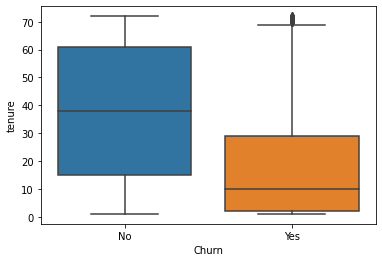

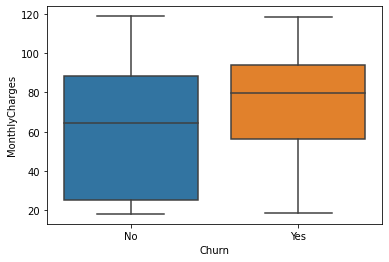

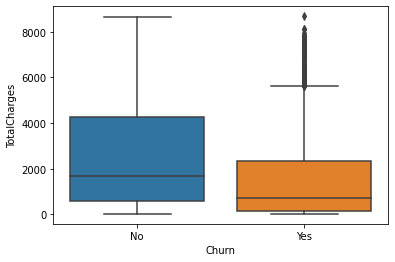

In [8]:
def plothist(col):
  plt.figure()
  ax = sns.boxplot(x="Churn", y=col, data=telcom)


for col in num_cols:
  plothist(col)

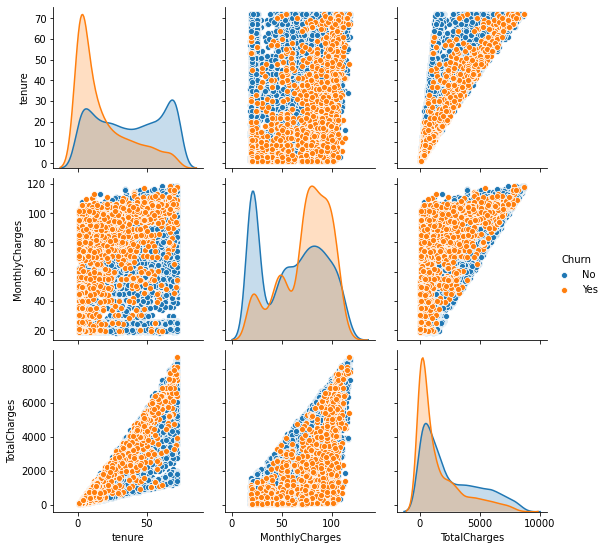

In [9]:
sns.pairplot(telcom[num_cols + ['Churn']], hue="Churn")

**3.4 Churn vs Not Churn - Tenure Groups**

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

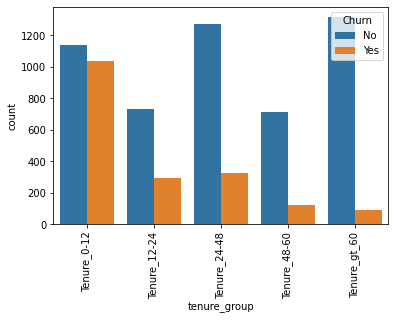

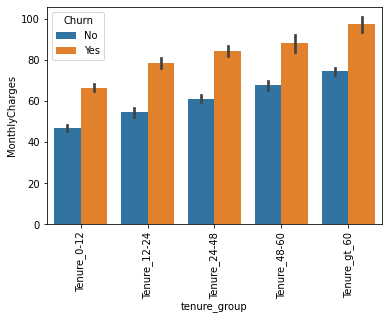

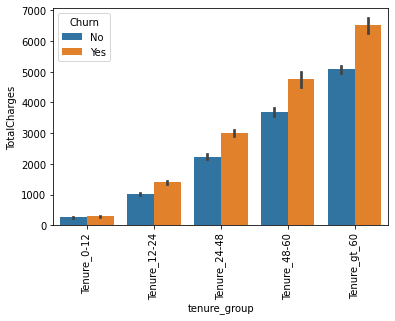

In [10]:
tenures = sorted(telcom["tenure_group"].unique())

ax = sns.countplot(x="tenure_group", hue="Churn", data=telcom,order=tenures)
plt.xticks(rotation=90)

plt.figure()


ax = sns.barplot(x="tenure_group", y="MonthlyCharges", hue='Churn', data=telcom, estimator=np.mean,order=tenures)
plt.xticks(rotation=90)

plt.figure()
ax = sns.barplot(x="tenure_group", y="TotalCharges", hue='Churn', data=telcom, estimator=np.mean,order=tenures)
plt.xticks(rotation=90)
#
#tmp_df = pd.DataFrame(telcom.groupby(['Churn'])['TotalCharges'].mean()).reset_index()
#tmp_df.columns = ['Churn','Avg Total Charges']
#ax = sns.countplot(x="Avg Total Charges", hue="Churn", data=tmp_df)
#plt.xticks(rotation=90)
#

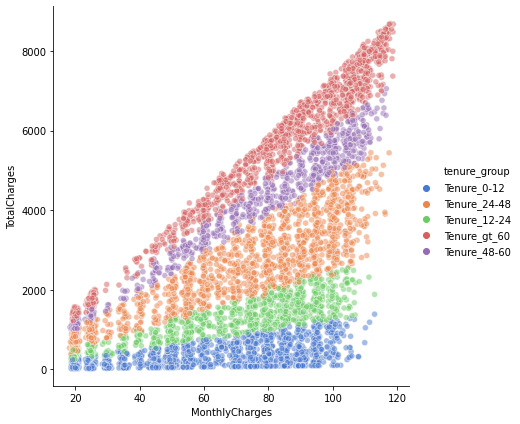

<Figure size 432x288 with 0 Axes>

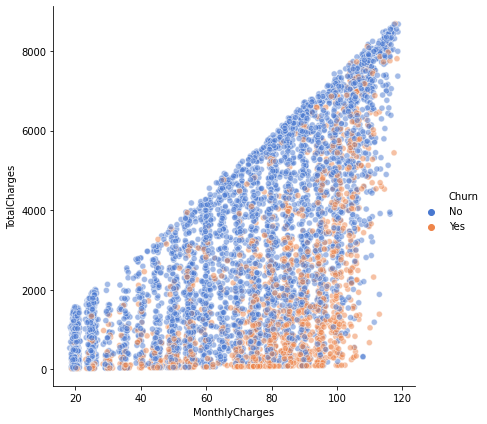

In [11]:
sns.relplot(x="MonthlyCharges", y="TotalCharges", hue="tenure_group", alpha=.5, palette="muted",
            height=6, data=telcom)
plt.figure()
sns.relplot(x="MonthlyCharges", y="TotalCharges", hue="Churn", alpha=.5, palette="muted",
            height=6, data=telcom)

# **4. Data Processing**

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

In [13]:

telcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7032 non-null   object 
 1   gender                                   7032 non-null   int64  
 2   SeniorCitizen                            7032 non-null   int64  
 3   Partner                                  7032 non-null   int64  
 4   Dependents                               7032 non-null   int64  
 5   PhoneService                             7032 non-null   int64  
 6   OnlineSecurity                           7032 non-null   int64  
 7   OnlineBackup                             7032 non-null   int64  
 8   DeviceProtection                         7032 non-null   int64  
 9   TechSupport                              7032 non-null   int64  
 10  StreamingTV                              7032 no

# **5. Dimension Reduction**

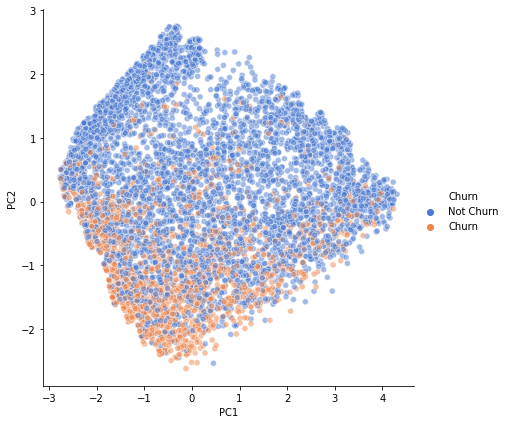

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

sns.relplot(x="PC1", y="PC2", hue="Churn", alpha=.5, palette="muted",
            height=6, data=pca_data)


# **6. Predictive Modelling**

**6.1 Train-Test Split**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
#splitting train and test data 
telcom = telcom.drop(columns = Id_col,axis = 1)
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
#cols    = [i for i in telcom.columns if i not in Id_col + target_col]
#train_X = train[cols]
#train_Y = train[target_col]
#test_X  = test[cols]
#test_Y  = test[target_col]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 1386 to 3924
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   5274 non-null   int64  
 1   SeniorCitizen                            5274 non-null   int64  
 2   Partner                                  5274 non-null   int64  
 3   Dependents                               5274 non-null   int64  
 4   PhoneService                             5274 non-null   int64  
 5   OnlineSecurity                           5274 non-null   int64  
 6   OnlineBackup                             5274 non-null   int64  
 7   DeviceProtection                         5274 non-null   int64  
 8   TechSupport                              5274 non-null   int64  
 9   StreamingTV                              5274 non-null   int64  
 10  StreamingMovies                          5274

**6.2 PyCaret Setup**

In [18]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode activated.


In [25]:
features = train.columns.tolist()
features.remove('Churn')

In [26]:
from pycaret.classification import *
exp_clf101 = setup(data = train, target = 'Churn',numeric_features=features, session_id=123) 

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(5274, 34)"
4,Missing Values,False
5,Numeric Features,33
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


**6.3 Compare Models**

In [27]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.8125,0.8441,0.5318,0.6818,0.5971,0.4775,0.4840,0.0996
1,Extreme Gradient Boosting,0.8117,0.8453,0.5287,0.6802,0.5941,0.4743,0.4811,0.3065
2,Ridge Classifier,0.8109,0.0000,0.4996,0.6921,0.5795,0.4618,0.4724,0.0108
3,Linear Discriminant Analysis,0.8085,0.8390,0.5317,0.6689,0.5918,0.4689,0.4746,0.0337
4,Gradient Boosting Classifier,0.8076,0.8429,0.5266,0.6666,0.5877,0.4648,0.4706,0.6689
5,Ada Boost Classifier,0.8044,0.8444,0.5163,0.6597,0.5780,0.4537,0.4600,0.2542
6,CatBoost Classifier,0.8017,0.8373,0.5048,0.6577,0.5696,0.4441,0.4515,4.0279
7,SVM - Linear Kernel,0.7998,0.0000,0.5009,0.6804,0.5536,0.4336,0.4541,0.0435
8,Light Gradient Boosting Machine,0.7963,0.8284,0.5214,0.6340,0.5708,0.4393,0.4437,0.1581
9,Extra Trees Classifier,0.7938,0.8039,0.5006,0.6343,0.5591,0.4271,0.4325,0.4523


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**6.4 Create A Model**

In [28]:
xboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8135,0.8618,0.5670,0.6707,0.6145,0.4927,0.4957
1,0.7832,0.8304,0.4845,0.6104,0.5402,0.4008,0.4054
2,0.7995,0.8470,0.5361,0.6420,0.5843,0.4535,0.4567
3,0.8103,0.8440,0.4948,0.6957,0.5783,0.4604,0.4715
4,0.7751,0.8094,0.4124,0.6061,0.4908,0.3531,0.3639
5,0.8401,0.8668,0.5833,0.7467,0.6550,0.5529,0.5601
6,0.8184,0.8603,0.5312,0.6986,0.6036,0.4886,0.4963
7,0.8347,0.8628,0.5521,0.7465,0.6347,0.5310,0.5411
8,0.8157,0.8307,0.5208,0.6944,0.5952,0.4791,0.4874
9,0.8266,0.8399,0.6042,0.6905,0.6444,0.5304,0.5325


**6.5 Tune A Model**

In [30]:
tuned_xgboost= tune_model(xboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8135,0.8594,0.5155,0.6944,0.5917,0.4743,0.4831
1,0.7751,0.8350,0.3711,0.6207,0.4645,0.3334,0.3510
2,0.8022,0.8406,0.5155,0.6579,0.5780,0.4513,0.4570
3,0.7995,0.8402,0.4227,0.6949,0.5256,0.4079,0.4282
4,0.7751,0.7915,0.4124,0.6061,0.4908,0.3531,0.3639
5,0.8076,0.8480,0.4896,0.6812,0.5697,0.4500,0.4602
6,0.8184,0.8512,0.5104,0.7101,0.5939,0.4810,0.4919
7,0.8184,0.8530,0.4896,0.7231,0.5839,0.4732,0.4879
8,0.7940,0.7924,0.4688,0.6429,0.5422,0.4135,0.4221
9,0.8130,0.8347,0.5208,0.6849,0.5917,0.4733,0.4808


**6.6 Visualize The Tuned Model**

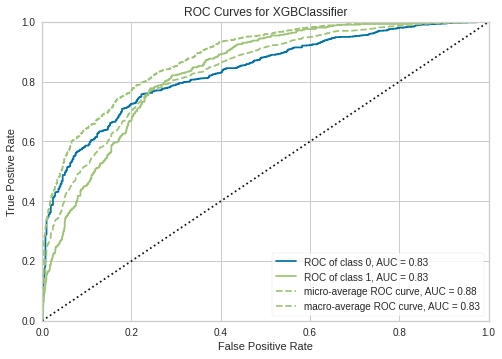

In [32]:
plot_model(tuned_xgboost, plot = 'auc')

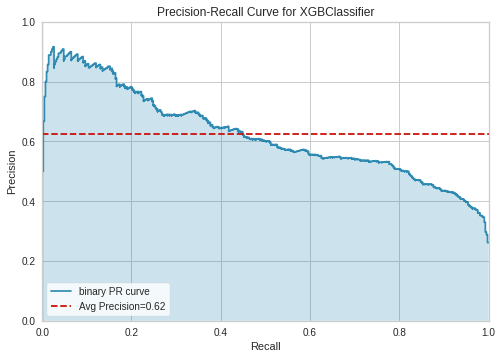

In [33]:
plot_model(tuned_xgboost, plot = 'pr')

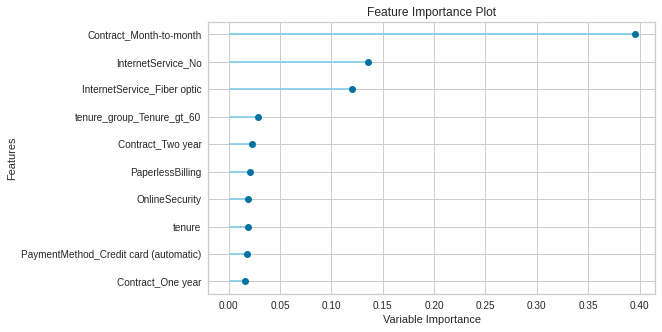

In [34]:
plot_model(tuned_xgboost, plot='feature')

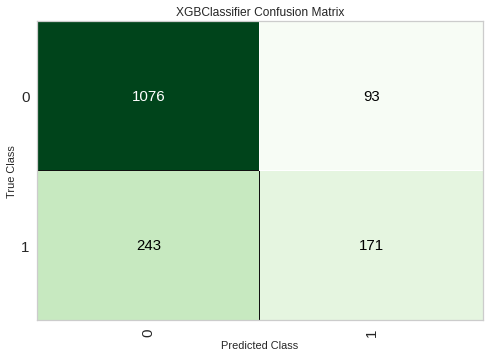

In [35]:
plot_model(tuned_xgboost, plot = 'confusion_matrix')

**6.7 Prediction On Hold-out Set**

In [36]:
predict_model(tuned_xgboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7877,0.8339,0.413,0.6477,0.5044,0.3777,0.3932


**6.8 Finalize The Model**

In [37]:
final_xgboost = finalize_model(tuned_xgboost)

In [39]:
#Final Random Forest model parameters for deployment
print(final_xgboost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.07, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=0)


In [40]:
predict_model(final_xgboost);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8212,0.8728,0.5024,0.7298,0.5951,0.4854,0.4993


In [41]:
unseen_predictions = predict_model(final_xgboost, data=test)
unseen_predictions.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_12-24,tenure_group_Tenure_24-48,tenure_group_Tenure_48-60,tenure_group_Tenure_gt_60,tenure,MonthlyCharges,TotalCharges,Label,Score
0,1,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,-0.995040,-0.448686,-0.825771,0,0.3178
1,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,-0.465369,-0.761147,-0.636722,0,0.4732
2,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,-0.302393,-1.263077,-0.683730,0,0.2709
3,0,0,1,0,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1.490341,1.701970,2.602807,0,0.2775
4,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0.023559,0.186206,0.054178,1,0.5061


**6.8 Save & Load**

In [42]:
save_model(final_xgboost,'Final xgboost Model 13_08_2020')

Transformation Pipeline and Model Succesfully Saved


In [43]:
saved_final_xgboost = load_model('Final xgboost Model 13_08_2020')

Transformation Pipeline and Model Sucessfully Loaded


In [46]:
new_prediction = predict_model(saved_final_xgboost, data=test)

In [47]:
new_prediction.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_12-24,tenure_group_Tenure_24-48,tenure_group_Tenure_48-60,tenure_group_Tenure_gt_60,tenure,MonthlyCharges,TotalCharges,Label,Score
0,1,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,-0.995040,-0.448686,-0.825771,0,0.3178
1,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,-0.465369,-0.761147,-0.636722,0,0.4732
2,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,-0.302393,-1.263077,-0.683730,0,0.2709
3,0,0,1,0,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1.490341,1.701970,2.602807,0,0.2775
4,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0.023559,0.186206,0.054178,1,0.5061
